## LMRO Clustering Analysis

First lets import the packages needed to build the clusters

In [1]:
# Import functions
import json
import networkx as nx
import numpy as np
from itertools import count, groupby
import matplotlib as plt


# Import custom libraries
from  qaoa_vrp.utils import read_instance
from qaoa_vrp.build_graph import *
from qaoa_vrp.build_circuit import build_qubos,qubo_to_qaoa
import qaoa_vrp.clustering as clustering


from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

np.random.seed(0)

/home/floyd/.local/share/virtualenvs/qaoa-vrp-ZjxpDs-G/lib/python3.9/site-packages/qiskit/__init__.py:72: RuntimeWarning: Could not import the IBMQ provider from the qiskit-ibmq-provider package. Install qiskit-ibmq-provider or check your installation.
  warnings.warn('Could not import the IBMQ provider from the '


Import data from test case

In [2]:
data, num_vehicles = read_instance('../data/test.json')
# print data nicely if you want
print(json.dumps(data, indent=4))


{
    "nodes": [
        {
            "tag": "Depot",
            "supplies": [],
            "id": "f19ffedf-c0e8-4669-b065-c03eed51b8f8"
        },
        {
            "tag": "",
            "supplies": [],
            "id": "74ecd4d0-58d9-4803-b5c5-9b2ae8b2f870"
        },
        {
            "tag": "",
            "supplies": [],
            "id": "cda1e8be-7e64-446f-98bf-6396b45a8791"
        },
        {
            "tag": "",
            "supplies": [],
            "id": "c1adcb61-a785-4ade-aece-5bb5e40bff20"
        },
        {
            "tag": "",
            "supplies": [],
            "id": "2d2fe3ca-a05f-4a9e-b90d-1a24ddff7485"
        },
        {
            "tag": "",
            "supplies": [],
            "id": "ae2be248-3923-44f7-8e40-d05bdff29354"
        },
        {
            "tag": "",
            "supplies": [],
            "id": "c62ec2dc-9079-4f00-b0b9-39b6ab1a342c"
        }
    ],
    "edges": [
        {
            "source": "f19ffedf-c0e8-4669-b0

Read in the `test` graph from JSON and build a cost matrix and the graph using `networkX`

In [3]:
G, depot_info = build_json_graph(data)

Awesome, let's look at our graph

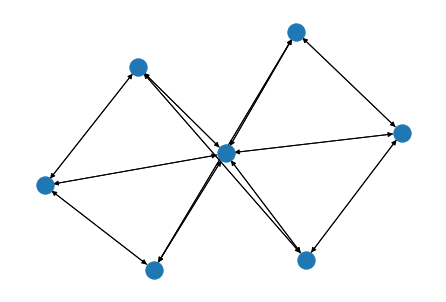

In [4]:
nx.draw(G)

Since we're going to be separating the nodes into different clusters for our VRP, let's remove the depot from our graph. **BUT** the information ab

In [5]:
depot_edges = list(G.edges(depot_info['id'], data=True))
depot_node = depot_info['id']

In [6]:
G.remove_node(depot_info['id'])

We can now construct the cost and adjacency matrices

In [7]:
edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray() # Adjacency Matrix
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes()))) # Cost Matrix

Let's have a look at the edge matrix and cost matrix

In [8]:
edge_mat

array([[0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0.]])

In [9]:
cost_mat

array([[0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0.]])

Let's use spectral clustering to cluster the nodes!

In [10]:
G, cluster_mapping = clustering.create_clusters(G,num_vehicles, "spectral-clustering", edge_mat)
for node in G.nodes(data=True):
    print(node)

('74ecd4d0-58d9-4803-b5c5-9b2ae8b2f870', {'cluster': 2})
('cda1e8be-7e64-446f-98bf-6396b45a8791', {'cluster': 2})
('c1adcb61-a785-4ade-aece-5bb5e40bff20', {'cluster': 1})
('2d2fe3ca-a05f-4a9e-b90d-1a24ddff7485', {'cluster': 1})
('ae2be248-3923-44f7-8e40-d05bdff29354', {'cluster': 1})
('c62ec2dc-9079-4f00-b0b9-39b6ab1a342c', {'cluster': 2})


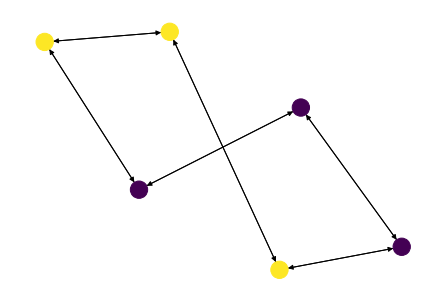

In [11]:
nx.draw(G, node_color=cluster_mapping)

In [12]:
subgraphs = clustering.build_sub_graphs(G, depot_node, depot_edges)

[1, 1, 1, 0]


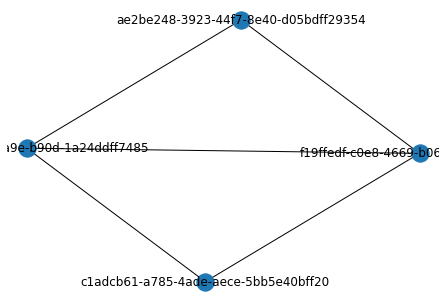

In [13]:
clustering.draw_sub_graph(subgraphs[1])

[2, 2, 2, 0]


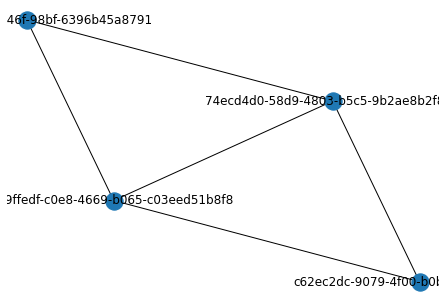

In [14]:
clustering.draw_sub_graph(subgraphs[2])

## Lets go QUANTUM


In [15]:
subgraphs

{1: <networkx.classes.graph.Graph at 0x7ff936485fd0>,
 2: <networkx.classes.graph.Graph at 0x7ff936485d90>}

In [16]:
qubos = build_qubos(subgraphs, depot_info)
qubo = qubos[0]

In [17]:
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
from qiskit.optimization import QuadraticProgram

In [18]:
quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                   seed_simulator=aqua_globals.random_seed,
                                   seed_transpiler=aqua_globals.random_seed)
qaoa = MinimumEigenOptimizer(quantum_instance)   # using QAOA
qaoa_mes = QAOA(quantum_instance=quantum_instance,p=2, initial_point=list(np.random.random(4)))
exact_mes = NumPyMinimumEigensolver()

AttributeError: 'QuantumInstance' object has no attribute 'supports_aux_operators'

In [ ]:
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver


In [ ]:
qaoa_result = qaoa.solve(qubo)
print("%%%% SOLVING QAOA %%%%")
print(qaoa_result)


In [ ]:
exact_result = exact.solve(qubo)
print("%%%% SOLVING USING CPLEX %%%%")
print(exact_result)

In [ ]:
rqaoa = RecursiveMinimumEigenOptimizer(qaoa)

In [ ]:
rqaoa.get_compatibility_msg(qubo)

In [ ]:
rqaoa.is_compatible(qubo)

In [ ]:
rqaoa.solve(qubo)

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table

In [ ]:
qiskit.__version__